# NFDI4Earth Knowledge Hub × geoextent

**Exploring repository and dataset coverage in the NFDI4Earth infrastructure with [geoextent](https://nuest.github.io/geoextent/)**

This notebook demonstrates how [geoextent](https://github.com/nuest/geoextent) can extract geospatial and temporal extents from research data repositories that are part of the [NFDI4Earth](https://www.nfdi4earth.de/) consortium. All metadata queries use the [NFDI4Earth Knowledge Hub](https://knowledgehub.nfdi4earth.de/) SPARQL endpoint, and the results are publicly displayed in the [NFDI4Earth OneStop4All](https://onestop4all.nfdi4earth.de/) portal.

**Contents:**

1. [Setup](#setup) — Imports and SPARQL helper
2. [NFDI4Earth Repositories](#repos) — Labelled and harvested repositories
3. [geoextent Support Mapping](#mapping) — Combined overview table
4. [Metadata Standards & APIs](#standards) — Knowledge Hub example query
5. [Dataset Coverage](#coverage) — Spatial and temporal metadata in the Knowledge Hub
6. [geoextent in Action](#demo) — Live extraction from supported repositories
7. [Conclusions](#conclusions)

<a id="setup"></a>

## 1. Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import folium
from folium.plugins import MarkerCluster
from IPython.display import display, Markdown

from SPARQLWrapper import SPARQLWrapper, JSON, POST

import geoextent.lib.extent as geoextent
from geoextent import __version__ as geoextent_version

print(f"geoextent version: {geoextent_version}")

geoextent version: 0.12.1.dev35+ge4a21e18c.d20260217


In [2]:
# NFDI4Earth Knowledge Hub SPARQL endpoint
KH_SPARQL_ENDPOINT = "https://sparql.knowledgehub.nfdi4earth.de/"

# Common prefixes used across queries
PREFIXES = """
PREFIX n4e:    <http://nfdi4earth.de/ontology/>
PREFIX rdf:    <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX dct:    <http://purl.org/dc/terms/>
PREFIX dcat:   <http://www.w3.org/ns/dcat#>
PREFIX foaf:   <http://xmlns.com/foaf/0.1/>
PREFIX schema: <http://schema.org/>
PREFIX locn:   <http://www.w3.org/ns/locn#>
PREFIX skos:   <http://www.w3.org/2004/02/skos/core#>
"""


def sparql_query(query, endpoint=KH_SPARQL_ENDPOINT):
    """Execute a SPARQL SELECT query and return results as a pandas DataFrame."""
    sparql = SPARQLWrapper(endpoint)
    sparql.setMethod(POST)
    sparql.setQuery(PREFIXES + query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    bindings = results["results"]["bindings"]
    if not bindings:
        return pd.DataFrame()

    rows = []
    for b in bindings:
        row = {}
        for var in results["head"]["vars"]:
            if var in b:
                row[var] = b[var]["value"]
            else:
                row[var] = None
        rows.append(row)
    return pd.DataFrame(rows)


print(f"SPARQL endpoint: {KH_SPARQL_ENDPOINT}")

SPARQL endpoint: https://sparql.knowledgehub.nfdi4earth.de/


<a id="repos"></a>

## 2. Repositories in NFDI4Earth

The NFDI4Earth Knowledge Hub indexes research data repositories via [re3data](https://www.re3data.org/) metadata. Repositories can be:

- **NFDI4Earth Labelled** — repositories that have been evaluated and awarded the [NFDI4Earth Label](https://onestop4all.nfdi4earth.de/search?resourcetype=Repository+%26+Archive&isN4ELabelled=true&sort=)
- **Harvested by NFDI4Earth** — repositories whose dataset metadata has been harvested into the Knowledge Hub and is searchable via the [OneStop4All](https://onestop4all.nfdi4earth.de/search?resourcetype=Repository+%26+Archive&isHarvestedByNFDI4Earth=true&sort=)

### 2.1 NFDI4Earth-Labelled Repositories

In [3]:
df_labelled = sparql_query("""
SELECT ?repo ?title ?homepage
WHERE {
    ?repo rdf:type n4e:Repository ;
          dct:title ?title ;
          foaf:homepage ?homepage ;
          n4e:isNFDI4EarthLabelled true .
    FILTER(LANG(?title) = 'en' || LANG(?title) = '')
}
ORDER BY ?title
""")

print(f"Found {len(df_labelled)} NFDI4Earth-labelled repositories:")
df_labelled[["title", "homepage"]]

Found 10 NFDI4Earth-labelled repositories:


,title,homepage
0,Biodiversity Exploratories Information System,https://www.bexis.uni-jena.de/
1,DEIMS-SDR,https://deims.org
2,Edaphobase,https://portal.edaphobase.org
3,Edmond,https://edmond.mpg.de
4,GEOFON,https://geofon.gfz.de/
5,OceanRep GEOMAR Repository,https://oceanrep.geomar.de/
6,PANGAEA,https://www.pangaea.de/
7,World Data Center for Climate,https://www.wdc-climate.de/ui/
8,World Stress Map,https://www.world-stress-map.org/
9,heiDATA,https://heidata.uni-heidelberg.de


### 2.2 Repositories Harvested by NFDI4Earth

These are repositories whose dataset-level metadata has been ingested into the Knowledge Hub. We count the number of datasets per repository catalog (`n4e:inCatalog`).

In [4]:
df_harvested = sparql_query("""
SELECT ?repoTitle ?homepage (COUNT(DISTINCT ?dataset) AS ?datasetCount)
WHERE {
    ?dataset a dcat:Dataset ;
             n4e:inCatalog ?repo .
    ?repo a n4e:Repository ;
          dct:title ?repoTitle ;
          foaf:homepage ?homepage .
    FILTER(LANG(?repoTitle) = 'en' || LANG(?repoTitle) = '')
}
GROUP BY ?repoTitle ?homepage
ORDER BY DESC(?datasetCount)
""")

df_harvested["datasetCount"] = pd.to_numeric(df_harvested["datasetCount"])
print(f"Found {len(df_harvested)} harvested repositories with {df_harvested['datasetCount'].sum():,.0f} total datasets:")
df_harvested

Found 8 harvested repositories with 466,249 total datasets:


,repoTitle,homepage,datasetCount
0,PANGAEA,https://www.pangaea.de/,439345
1,NERC Data Catalogue Service,https://data-search.nerc.ac.uk/geonetwork/srv/...,17129
2,World Data Center for Climate,https://www.wdc-climate.de/ui/,6976
3,GFZ Data Services,https://dataservices.gfz.de/,2588
4,ARM Data Center,https://www.arm.gov/data,98
5,NSF Arctic Data Center,https://arcticdata.io/,72
6,ioerDATA,https://data.fdz.ioer.de/,31
7,Zenodo,https://zenodo.org/,10


<a id="mapping"></a>

## 3. geoextent Support Mapping

geoextent supports [20 research data repositories](https://nuest.github.io/geoextent/providers.html) as content providers. The following table maps NFDI4Earth repositories to geoextent provider classes by matching repository homepage URLs.

A checkmark (\u2705) indicates that geoextent can directly download and extract geospatial/temporal extents from that repository using `geoextent.fromRemote()`. A cross (\u274c) means no provider exists yet.

In [5]:
# Mapping of repository homepage substrings to geoextent provider info
GEOEXTENT_PROVIDERS = {
    "pangaea.de":                {"provider": "Pangaea",           "doi_example": "10.1594/PANGAEA.909658"},
    "dataservices.gfz":          {"provider": "GFZ",               "doi_example": "10.5880/GFZ.1.1.2024.002"},
    "zenodo.org":                {"provider": "Zenodo",            "doi_example": "10.5281/zenodo.4593540"},
    "edmond.mpg.de":             {"provider": "Dataverse (Edmond)","doi_example": "10.17617/3.DQHWMV"},
    "heidata.uni-heidelberg.de": {"provider": "Dataverse (heiDATA)","doi_example": "10.11588/data/N5TSI1"},
    "arcticdata.io":             {"provider": "ArcticDataCenter",  "doi_example": "10.18739/A2KW57K57"},
    "deims.org":                 {"provider": "DEIMS-SDR",         "doi_example": None},
    "data.fdz.ioer.de":          {"provider": "Dataverse (ioerDATA)","doi_example": None},
}


def match_provider(homepage):
    """Match a repository homepage URL to a geoextent provider."""
    if homepage is None:
        return None
    for pattern, info in GEOEXTENT_PROVIDERS.items():
        if pattern in homepage:
            return info["provider"]
    return None


# Build combined overview of all NFDI4Earth repositories
all_repos = {}

# Add labelled repositories
for _, row in df_labelled.iterrows():
    key = row["homepage"]
    all_repos[key] = {
        "Repository": row["title"],
        "Homepage": row["homepage"],
        "N4E Label": "\u2705",
        "Harvested": "",
        "Datasets": 0,
    }

# Add/update with harvested repositories
for _, row in df_harvested.iterrows():
    key = row["homepage"]
    if key in all_repos:
        all_repos[key]["Harvested"] = "\u2705"
        all_repos[key]["Datasets"] = int(row["datasetCount"])
    else:
        all_repos[key] = {
            "Repository": row["repoTitle"],
            "Homepage": row["homepage"],
            "N4E Label": "",
            "Harvested": "\u2705",
            "Datasets": int(row["datasetCount"]),
        }

# Create DataFrame and add geoextent support
df_overview = pd.DataFrame(all_repos.values())
df_overview["geoextent Provider"] = df_overview["Homepage"].apply(match_provider)
df_overview["Supported"] = df_overview["geoextent Provider"].apply(
    lambda x: "\u2705" if x else "\u274c"
)

# Sort: labelled first, then by dataset count
df_overview = df_overview.sort_values(
    ["N4E Label", "Datasets"], ascending=[False, False]
).reset_index(drop=True)

n_supported = df_overview["geoextent Provider"].notna().sum()
n_total = len(df_overview)
print(f"Combined overview: {n_total} repositories, {n_supported} supported by geoextent")
print()

df_overview[["Repository", "N4E Label", "Harvested", "Datasets", "Supported", "geoextent Provider"]]

Combined overview: 16 repositories, 8 supported by geoextent



,Repository,N4E Label,Harvested,Datasets,Supported,geoextent Provider
0,PANGAEA,✅,✅,439345,✅,Pangaea
1,World Data Center for Climate,✅,✅,6976,❌,None
2,Biodiversity Exploratories Information System,✅,,0,❌,None
3,DEIMS-SDR,✅,,0,✅,DEIMS-SDR
4,Edaphobase,✅,,0,❌,None
5,Edmond,✅,,0,✅,Dataverse (Edmond)
6,GEOFON,✅,,0,❌,None
7,OceanRep GEOMAR Repository,✅,,0,❌,None
8,World Stress Map,✅,,0,❌,None
9,heiDATA,✅,,0,✅,Dataverse (heiDATA)


In [6]:
# Summary statistics
labelled_total = (df_overview["N4E Label"] == "\u2705").sum()
labelled_supported = ((df_overview["N4E Label"] == "\u2705") & df_overview["geoextent Provider"].notna()).sum()
harvested_total = (df_overview["Harvested"] == "\u2705").sum()
harvested_supported = ((df_overview["Harvested"] == "\u2705") & df_overview["geoextent Provider"].notna()).sum()
harvested_datasets = df_overview.loc[df_overview["Harvested"] == "\u2705", "Datasets"].sum()
supported_datasets = df_overview.loc[
    (df_overview["Harvested"] == "\u2705") & df_overview["geoextent Provider"].notna(), "Datasets"
].sum()

display(Markdown(f"""### Coverage Summary

| Category | Total | Supported by geoextent | Coverage |
|---|---|---|---|
| N4E-Labelled Repositories | {labelled_total} | {labelled_supported} | {labelled_supported/labelled_total*100:.0f}% |
| Harvested Repositories | {harvested_total} | {harvested_supported} | {harvested_supported/harvested_total*100:.0f}% |
| Datasets (in harvested repos) | {harvested_datasets:,} | {supported_datasets:,} (in supported repos) | {supported_datasets/harvested_datasets*100:.1f}% |
"""))

### Coverage Summary

| Category | Total | Supported by geoextent | Coverage |
|---|---|---|---|
| N4E-Labelled Repositories | 10 | 4 | 40% |
| Harvested Repositories | 8 | 5 | 62% |
| Datasets (in harvested repos) | 466,249 | 442,046 (in supported repos) | 94.8% |


<a id="standards"></a>

## 4. Metadata Standards & API Support

This query is adapted from the [Knowledge Hub landing page example queries](https://knowledgehub.nfdi4earth.de/). It shows which metadata standards and API protocols each repository supports — useful context for understanding how geoextent accesses repository data.

In [7]:
df_standards = sparql_query("""
SELECT ?repositoryName ?standardName ?apiType
WHERE {
    ?standard a n4e:MetadataStandard .
    ?standard dct:title ?standardName .
    ?repo a n4e:Repository .
    ?repo dct:title ?repositoryName .
    ?repo n4e:supportsMetadataStandard ?standard .
    ?repo n4e:hasAPI ?api .
    ?api dct:conformsTo ?apiType .
    FILTER(LANG(?repositoryName) = 'en' || LANG(?repositoryName) = '')
}
ORDER BY ?repositoryName ?standardName
""")

if not df_standards.empty:
    # Pivot: group standards and APIs per repository
    df_std_grouped = df_standards.groupby("repositoryName").agg(
        standards=("standardName", lambda x: ", ".join(sorted(set(x)))),
        apis=("apiType", lambda x: ", ".join(sorted(set(x)))),
    ).reset_index()
    df_std_grouped.columns = ["Repository", "Metadata Standards", "API Protocols"]
    print(f"Found metadata standard information for {len(df_std_grouped)} repositories:")
    display(df_std_grouped)
else:
    print("No metadata standard information found.")

Found metadata standard information for 47 repositories:


,Repository,Metadata Standards,API Protocols
0,ACTRIS Data Centre,CF (Climate and Forecast) Metadata Conventions...,"OpenDAP, REST"
1,ARM Data Center,CF (Climate and Forecast) Metadata Conventions...,"NetCDF, REST"
2,Australian Ocean Data Network Portal,ISO 19115,"NetCDF, OpenDAP"
3,B2FIND,"DDI (Data Documentation Initiative), Dublin Co...",OAI-PMH
4,BacDive,DataCite Metadata Schema,REST
5,Biodiversity Exploratories Information System,"Darwin Core, DataCite Metadata Schema, Reposit...",REST
6,British Oceanographic Data Centre,"DIF (Directory Interchange Format), Dublin Cor...",NetCDF
7,CDC - Climate Data Center,ISO 19115,FTP
8,Crystallography Open Database,CIF (Crystallographic Information Framework),REST
9,DEIMS-SDR,ISO 19115,"OAI-PMH, REST"


<a id="coverage"></a>

## 5. Dataset Coverage in the Knowledge Hub

How many datasets in the Knowledge Hub already have spatial or temporal metadata? This analysis reveals the current state — and the gap that geoextent could help fill by extracting extents from the actual data files.

### 5.1 Datasets with Spatial Metadata

In [8]:
df_spatial = sparql_query("""
SELECT ?repoTitle (COUNT(DISTINCT ?dataset) AS ?withSpatial)
WHERE {
    ?dataset a dcat:Dataset ;
             n4e:inCatalog ?repo ;
             dct:spatial ?spatial .
    ?spatial locn:geometry ?geom .
    ?repo a n4e:Repository ;
          dct:title ?repoTitle .
    FILTER(LANG(?repoTitle) = 'en' || LANG(?repoTitle) = '')
}
GROUP BY ?repoTitle
ORDER BY DESC(?withSpatial)
""")

if not df_spatial.empty:
    df_spatial["withSpatial"] = pd.to_numeric(df_spatial["withSpatial"])
    print(f"Datasets with spatial metadata across {len(df_spatial)} repositories:")
    display(df_spatial)
else:
    print("No datasets with spatial metadata found (or query timed out).")

Datasets with spatial metadata across 5 repositories:


,repoTitle,withSpatial
0,PANGAEA,433810
1,NERC Data Catalogue Service,16000
2,GFZ Data Services,264
3,NSF Arctic Data Center,72
4,World Data Center for Climate,41


### 5.2 Datasets with Temporal Metadata

In [9]:
df_temporal = sparql_query("""
SELECT ?repoTitle (COUNT(DISTINCT ?dataset) AS ?withTemporal)
WHERE {
    ?dataset a dcat:Dataset ;
             n4e:inCatalog ?repo ;
             dct:temporal ?temporal .
    ?temporal dcat:startDate ?start .
    ?repo a n4e:Repository ;
          dct:title ?repoTitle .
    FILTER(LANG(?repoTitle) = 'en' || LANG(?repoTitle) = '')
}
GROUP BY ?repoTitle
ORDER BY DESC(?withTemporal)
""")

if not df_temporal.empty:
    df_temporal["withTemporal"] = pd.to_numeric(df_temporal["withTemporal"])
    print(f"Datasets with temporal metadata across {len(df_temporal)} repositories:")
    display(df_temporal)
else:
    print("No datasets with temporal metadata found (or query timed out).")

Datasets with temporal metadata across 2 repositories:


,repoTitle,withTemporal
0,PANGAEA,356134
1,NERC Data Catalogue Service,16756


### Dataset Metadata Coverage by Repository

,Repository,Total Datasets,With Spatial,% Spatial,With Temporal,% Temporal,Supported
0,PANGAEA,439345,433810,98.7,356134,81.1,✅
1,NERC Data Catalogue Service,17129,16000,93.4,16756,97.8,❌
2,World Data Center for Climate,6976,41,0.6,0,0.0,❌
3,GFZ Data Services,2588,264,10.2,0,0.0,✅
4,ARM Data Center,98,0,0.0,0,0.0,❌
5,NSF Arctic Data Center,72,72,100.0,0,0.0,✅
6,ioerDATA,31,0,0.0,0,0.0,✅
7,Zenodo,10,0,0.0,0,0.0,✅


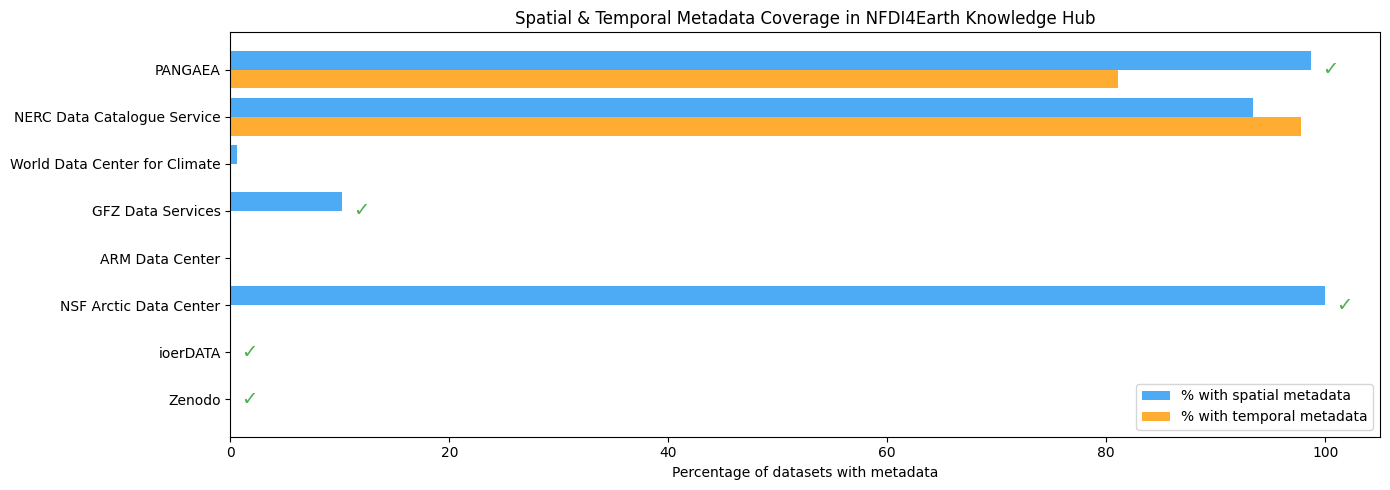

In [10]:
# Merge harvested counts with spatial/temporal coverage
df_cov = df_harvested.rename(columns={"repoTitle": "Repository", "datasetCount": "Total Datasets"}).copy()

if not df_spatial.empty and "repoTitle" in df_spatial.columns:
    df_cov = df_cov.merge(
        df_spatial.rename(columns={"repoTitle": "Repository", "withSpatial": "With Spatial"}),
        on="Repository", how="left",
    )
else:
    df_cov["With Spatial"] = 0

if not df_temporal.empty and "repoTitle" in df_temporal.columns:
    df_cov = df_cov.merge(
        df_temporal.rename(columns={"repoTitle": "Repository", "withTemporal": "With Temporal"}),
        on="Repository", how="left",
    )
else:
    df_cov["With Temporal"] = 0

df_cov["With Spatial"] = df_cov["With Spatial"].fillna(0).astype(int)
df_cov["With Temporal"] = df_cov["With Temporal"].fillna(0).astype(int)
df_cov["% Spatial"] = (df_cov["With Spatial"] / df_cov["Total Datasets"] * 100).round(1)
df_cov["% Temporal"] = (df_cov["With Temporal"] / df_cov["Total Datasets"] * 100).round(1)

# Add geoextent support flag
df_cov["geoextent"] = df_cov["homepage"].apply(match_provider)
df_cov["Supported"] = df_cov["geoextent"].apply(lambda x: "\u2705" if x else "\u274c")

display(Markdown("### Dataset Metadata Coverage by Repository"))
display(df_cov[["Repository", "Total Datasets", "With Spatial", "% Spatial",
                "With Temporal", "% Temporal", "Supported"]])

# Plot
fig, ax = plt.subplots(figsize=(14, max(5, len(df_cov) * 0.5)))
repos = df_cov["Repository"]
y = range(len(repos))
ax.barh(y, df_cov["% Spatial"], height=0.4, label="% with spatial metadata", color="#2196F3", alpha=0.8)
ax.barh([i + 0.4 for i in y], df_cov["% Temporal"], height=0.4, label="% with temporal metadata", color="#FF9800", alpha=0.8)

# Mark geoextent-supported repos
for i, (_, row) in enumerate(df_cov.iterrows()):
    if row["geoextent"]:
        ax.annotate("\u2713", xy=(max(row["% Spatial"], row["% Temporal"]) + 1, i + 0.2),
                     fontsize=14, fontweight="bold", color="#4CAF50", va="center")

ax.set_yticks([i + 0.2 for i in y])
ax.set_yticklabels(repos)
ax.set_xlabel("Percentage of datasets with metadata")
ax.set_title("Spatial & Temporal Metadata Coverage in NFDI4Earth Knowledge Hub")
ax.legend(loc="lower right")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

<a id="demo"></a>

## 6. geoextent in Action

We query the Knowledge Hub for sample dataset landing pages from repositories that geoextent supports, then run `geoextent.fromRemote()` to extract spatial and temporal extents directly from the data files.

### 6.1 Find Sample Datasets

In [11]:
# Query one sample dataset per supported harvested repository
# We query each repository individually to avoid PANGAEA dominating the results
supported_repos = df_overview.loc[
    df_overview["geoextent Provider"].notna() & (df_overview["Harvested"] == "\u2705"),
    ["Repository", "Homepage", "geoextent Provider"]
]

samples = []
for _, repo_row in supported_repos.iterrows():
    homepage = repo_row["Homepage"]
    df_sample = sparql_query(f"""
    SELECT ?datasetTitle ?landingPage
    WHERE {{
        ?dataset a dcat:Dataset ;
                 dct:title ?datasetTitle ;
                 dcat:landingPage ?landingPage ;
                 n4e:inCatalog ?repo .
        ?repo a n4e:Repository ;
              foaf:homepage <{homepage}> .
    }}
    LIMIT 1
    """)
    if not df_sample.empty:
        row = df_sample.iloc[0]
        samples.append({
            "Repository": repo_row["Repository"],
            "Provider": repo_row["geoextent Provider"],
            "Dataset": str(row["datasetTitle"])[:80],
            "Landing Page": row["landingPage"],
        })

df_demo = pd.DataFrame(samples)
if not df_demo.empty:
    print(f"Found sample datasets from {len(df_demo)} supported repositories via SPARQL:")
    display(df_demo)
else:
    print("No sample datasets found via SPARQL. Using fallback DOIs.")

# Always include well-known fallback DOIs for reliability
# (KH landing pages may use dx.doi.org which can differ from what geoextent expects)
fallback = pd.DataFrame([
    {"Repository": "PANGAEA", "Provider": "Pangaea",
     "Landing Page": "https://doi.org/10.1594/PANGAEA.842244"},
    {"Repository": "GFZ Data Services", "Provider": "GFZ",
     "Landing Page": "https://doi.org/10.5880/GFZ.2.3.2022.001"},
    {"Repository": "Zenodo", "Provider": "Zenodo",
     "Landing Page": "https://doi.org/10.5281/zenodo.4593540"},
])
# Merge: prefer SPARQL results, fill gaps with fallback
if df_demo.empty:
    df_demo = fallback
else:
    # Add fallback repos not already found via SPARQL
    existing_repos = set(df_demo["Repository"])
    for _, fb_row in fallback.iterrows():
        if fb_row["Repository"] not in existing_repos:
            df_demo = pd.concat([df_demo, pd.DataFrame([fb_row])], ignore_index=True)

print(f"\nWill demo {len(df_demo)} datasets:")
display(df_demo[["Repository", "Provider", "Landing Page"]])

Found sample datasets from 5 supported repositories via SPARQL:


,Repository,Provider,Dataset,Landing Page
0,PANGAEA,Pangaea,Stable isotope data of sediment core PS2837-5,https://doi.org/10.1594/PANGAEA.55435
1,GFZ Data Services,GFZ,GOCE calibrated and characterised magnetometer...,https://dx.doi.org/10.5880/GFZ.2.3.2022.001
2,NSF Arctic Data Center,ArcticDataCenter,"Turbulent flux measurements of carbon dioxide,...",https://dx.doi.org/doi:10.18739/A2D795C73
3,ioerDATA,Dataverse (ioerDATA),Land Use Structure Germany 2011,https://dx.doi.org/10.71830/37BMXE
4,Zenodo,Zenodo,Temperature and wind profiles measured with UA...,https://dx.doi.org/10.5281/zenodo.15600507



Will demo 5 datasets:


,Repository,Provider,Landing Page
0,PANGAEA,Pangaea,https://doi.org/10.1594/PANGAEA.55435
1,GFZ Data Services,GFZ,https://dx.doi.org/10.5880/GFZ.2.3.2022.001
2,NSF Arctic Data Center,ArcticDataCenter,https://dx.doi.org/doi:10.18739/A2D795C73
3,ioerDATA,Dataverse (ioerDATA),https://dx.doi.org/10.71830/37BMXE
4,Zenodo,Zenodo,https://dx.doi.org/10.5281/zenodo.15600507


### 6.2 Extract Extents with geoextent

Running `geoextent.fromRemote()` on each sample dataset. This downloads and analyses the actual data files — it may take a few minutes per dataset depending on file sizes and network speed.

In [12]:
import time


def normalize_url(url):
    """Normalize KH landing page URLs for geoextent compatibility."""
    # dx.doi.org -> doi.org
    url = url.replace("https://dx.doi.org/", "https://doi.org/")
    url = url.replace("http://dx.doi.org/", "https://doi.org/")
    # Remove spurious 'doi:' prefix in path (e.g., doi.org/doi:10.18739/...)
    url = url.replace("https://doi.org/doi:", "https://doi.org/")
    return url


results = []
max_demos = 3  # Limit to avoid long runtimes; increase to try more

for i, (_, row) in enumerate(df_demo.iterrows()):
    if i >= max_demos:
        break
    url = normalize_url(row["Landing Page"])
    repo = row["Repository"]
    print(f"\n[{i+1}/{min(len(df_demo), max_demos)}] {repo}: {url}")

    t0 = time.time()
    try:
        result = geoextent.fromRemote(url, bbox=True, tbox=True)
        elapsed = time.time() - t0
        results.append({
            "Repository": repo,
            "URL": row["Landing Page"],
            "bbox": result.get("bbox"),
            "crs": result.get("crs"),
            "tbox": result.get("tbox"),
            "Time (s)": round(elapsed, 1),
        })
        print(f"  bbox: {result.get('bbox')}")
        print(f"  tbox: {result.get('tbox')}")
        print(f"  time: {elapsed:.1f}s")
    except Exception as e:
        elapsed = time.time() - t0
        results.append({
            "Repository": repo,
            "URL": row["Landing Page"],
            "bbox": None,
            "crs": None,
            "tbox": None,
            "Time (s)": round(elapsed, 1),
        })
        print(f"  Error: {e} ({elapsed:.1f}s)")

df_results = pd.DataFrame(results)
print("\n--- Extraction Results ---")
display(df_results[["Repository", "bbox", "tbox", "Time (s)"]])


[1/3] PANGAEA: https://doi.org/10.1594/PANGAEA.55435


Processing pangaea_55435.csv:  50%|██████████████████████████████████████████▌                                          | 1/2 [00:00<00:00, 22.77task/s, Temporal extent extracted]
                                                                                                                                                                                   Error extracting tbox, time format not found 
 The csv file from /tmp/tmpton2pb0h/pangaea_55435.csv has no TemporalExtent:
Processing directory: tmpton2pb0h: 100%|█████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.36item/s, Processing pangaea_55435.csv]


  bbox: [81.233333333333, 2.3816666666667, 81.233333333333, 2.3816666666667]
  tbox: None
  time: 0.8s

[2/3] GFZ Data Services: https://doi.org/10.5880/GFZ.2.3.2022.001


Error downloading GFZ dataset: Could not find download URL on GFZ landing page
Error processing https://doi.org/10.5880/GFZ.2.3.2022.001: Could not find download URL on GFZ landing page


  Error: Could not find download URL on GFZ landing page (0.8s)

[3/3] NSF Arctic Data Center: https://doi.org/10.18739/A2D795C73


Processing MOSAiC_ship_flux_readme_V1_1.pdf:   0%|                                                                                                         | 0/2 [00:00<?, ?task/s]/tmp/tmp6vmw73fs/MOSAiC_ship_flux_readme_V1_1.pdf: No projection reference found and coordinates [0.0, 1650.0, 1275.0, 0.0] are outside valid WGS84 bounds. This typically indicates pixel coordinates from an ungeoreferenced raster. Skipping file (use --assume-wgs84 to force WGS84 interpretation).

Processing directory: tmp6vmw73fs:  33%|█████████████████▎                                  | 1/3 [00:00<00:00, 23.49item/s, Processing MOSAiC_ship_flux_co2_ch4_o3_dms_wk_v1_1.nc]
Processing MOSAiC_ship_flux_co2_ch4_o3_dms_wk_v1_1.nc:   0%|                                                                                               | 0/2 [00:00<?, ?task/s]Skipping layer 'MOSAiC_ship_flux_co2_ch4_o3_dms_wk_v1_1' in /tmp/tmp6vmw73fs/MOSAiC_ship_flux_co2_ch4_o3_dms_wk_v1_1.nc: degenerate extent [0,0,0,0] (possibly malfo

  bbox: None
  tbox: ['1970-01-01', '1970-01-01']
  time: 5.5s

--- Extraction Results ---


,Repository,bbox,tbox,Time (s)
0,PANGAEA,"[81.233333333333, 2.3816666666667, 81.23333333...",None,0.8
1,GFZ Data Services,None,None,0.8
2,NSF Arctic Data Center,None,"[1970-01-01, 1970-01-01]",5.5


### 6.3 Comparing Knowledge Hub Metadata vs. geoextent Extraction

For the datasets we just processed, let us compare the metadata already present in the Knowledge Hub (from harvesting) with what geoextent extracted from the actual data files.

In [13]:
# Query KH metadata for the same landing pages
# The KH uses dx.doi.org URLs while geoextent uses doi.org, so we try both variants
if not df_results.empty:
    landing_pages = df_results["URL"].tolist()
    # Also try dx.doi.org variants for doi.org URLs and vice versa
    all_lps = set(landing_pages)
    for lp in landing_pages:
        if "doi.org/" in lp:
            all_lps.add(lp.replace("https://doi.org/", "https://dx.doi.org/"))
            all_lps.add(lp.replace("https://dx.doi.org/", "https://doi.org/"))
    values_clause = " ".join(f"<{lp}>" for lp in all_lps)

    df_kh_meta = sparql_query(f"""
    SELECT ?landingPage ?geometry ?startDate ?endDate
    WHERE {{
        ?dataset a dcat:Dataset ;
                 dcat:landingPage ?landingPage .
        VALUES ?landingPage {{ {values_clause} }}
        OPTIONAL {{
            ?dataset dct:spatial ?spatial .
            ?spatial locn:geometry ?geometry .
        }}
        OPTIONAL {{
            ?dataset dct:temporal ?temporal .
            ?temporal dcat:startDate ?startDate .
            ?temporal dcat:endDate ?endDate .
        }}
    }}
    """)

    if not df_kh_meta.empty:
        # Normalize landing page URLs for matching
        def normalize_doi(url):
            if url:
                return url.replace("https://dx.doi.org/", "https://doi.org/")
            return url

        df_kh_meta["URL"] = df_kh_meta["landingPage"].apply(normalize_doi)
        df_results_norm = df_results.copy()
        df_results_norm["URL"] = df_results_norm["URL"].apply(normalize_doi)

        comparison = df_results_norm[["Repository", "URL", "bbox", "tbox"]].merge(
            df_kh_meta.rename(columns={
                "geometry": "KH Spatial (WKT)",
                "startDate": "KH Temporal Start",
                "endDate": "KH Temporal End",
            })[["URL", "KH Spatial (WKT)", "KH Temporal Start", "KH Temporal End"]],
            on="URL", how="left",
        )
        comparison = comparison.rename(columns={"bbox": "geoextent bbox", "tbox": "geoextent tbox"})
        display(Markdown("**Side-by-side: Knowledge Hub metadata vs. geoextent extraction**"))
        display(comparison)
    else:
        print("No KH metadata found for the sampled datasets.")
else:
    print("No geoextent results to compare.")

No KH metadata found for the sampled datasets.


## 7. Visualisation

Map of bounding boxes extracted by geoextent from NFDI4Earth Knowledge Hub datasets.

In [14]:
m = folium.Map(location=[50, 10], zoom_start=3, max_bounds=True)

for _, row in df_results.iterrows():
    bbox = row.get("bbox")
    if bbox and len(bbox) == 4:
        # bbox is [minlat, minlon, maxlat, maxlon] in default (non-legacy) mode
        minlat, minlon, maxlat, maxlon = bbox
        bounds = [[minlat, minlon], [maxlat, maxlon]]
        folium.Rectangle(
            bounds=bounds,
            color="#2196F3",
            fill=True,
            fill_opacity=0.2,
            popup=f"<b>{row['Repository']}</b><br>{row.get('URL', '')}",
        ).add_to(m)

m

<a id="conclusions"></a>

## 8. Conclusions

This notebook demonstrates the intersection of the [NFDI4Earth Knowledge Hub](https://knowledgehub.nfdi4earth.de/) and [geoextent](https://nuest.github.io/geoextent/):

1. **Repository Coverage**: geoextent already supports several NFDI4Earth-labelled and harvested repositories (PANGAEA, GFZ, Zenodo, heiDATA, Edmond, Arctic Data Center, DEIMS-SDR, ioerDATA). The remaining repositories could be added as new content providers.

2. **Metadata Gap**: The Knowledge Hub harvests dataset metadata from repositories, but not all datasets have spatial or temporal extent information. geoextent can fill this gap by extracting extents directly from the data files.

3. **Integration Potential**: By combining Knowledge Hub SPARQL queries with geoextent extraction, it is possible to:
   - Identify datasets lacking geospatial metadata
   - Automatically extract and propose extent metadata
   - Enrich the Knowledge Hub with file-level spatial and temporal coverage

### Next Steps

- **Extend provider support**: Add geoextent providers for additional NFDI4Earth repositories (e.g., GEOFON, World Data Center for Climate, NERC Data Catalogue Service)
- **Batch processing**: Run geoextent on larger sets of datasets from the Knowledge Hub to quantify the potential metadata enrichment
- **Feedback loop**: Propose extracted extents back to the Knowledge Hub or the original repositories to improve dataset discoverability
- **Quality assessment**: Compare geoextent-extracted extents with existing KH metadata to assess accuracy and identify improvements